# Kohonen maps on hand-written digits

**Nicolas Casademont & Teo Stocco**

1. [x] load data and selected data given by name2digits function
2. [x] Kohonen network
    - 6x6 unit distance grid,
    - gaussian neighbordhood with constant std 3
    - small constant learning rate
    - report "how you decide when your algorithm has converged"
    - visualize your prototypes and describe result
    - find a way to assign one digit to each prototype
3. [ ] explore 
    - different sizes of map (at least 3, not less than 36 units)
    - explore different width of neighborhood function
    - describe "role of witdth"
    - does the optimal width depend on map size?
    - start with large learning rate, reduce it over time, any improvements?
4. [ ] report (max. 4 pages)
    - choice of learning rate, description on convergence detection
    - visualization, description of learnt prototypes
    - visualization, description of digit-prototype assignment
    - results of network sizes and width exploration, discussion
    - results of varying width of neighborhood over time, discussion

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from helpers import name2digits

## 1 Setup

In [2]:
digits = name2digits('nicolas+teo')
digits

array([1, 2, 6, 8], dtype=uint8)

In [3]:
labels_all = np.loadtxt('labels.txt', dtype=np.int)
labels_all.shape

(5000,)

In [4]:
labels = labels_all[np.in1d(labels_all, digits)]
labels.shape

(2000,)

In [5]:
data_all = np.loadtxt('data.txt', dtype=np.int)
data_all.shape

(5000, 784)

In [6]:
data = data_all[np.in1d(labels_all, digits), :]
data.shape

(2000, 784)

## 2 Kohonen network

In [7]:
def neighborhood(x, mean, std):
    """Normalized neighborhood gaussian-like with mean and std."""
    return np.exp(- np.square(x - mean) / (2 * np.square(std)))

In [8]:
def som_step(centers, datapoint, neighbor, eta, sigma):
    """Learning step self-organized map updating inplace centers.
         centers   (matrix) cluster centres (center X dimension)
         datapoint (vector)
         neighbor  (matrix) coordinates of all centers
         eta       (scalar) learning rate
         sigma     (scalar) width/variance of neighborhood function
    """    
    k = np.argmin(np.sum(np.square(centers - datapoint), axis=1))
    k_coords = np.array(np.nonzero(neighbor == k))
        
    for j in range(len(centers)):
        j_coords = np.array(np.nonzero(neighbor == j))
        disc = neighborhood(np.linalg.norm(k_coords - j_coords), 0, sigma)
        centers[j, :] += disc * eta * (datapoint - centers[j, :])
    
    return np.sum(np.square(centers - datapoint)) / len(centers)

In [9]:
# total dimension
dim = 28 * 28
# dimension support
data_range = 255
# Kohonen map border size
size_k = 6
plt.rcParams['figure.figsize'] = (size_k, size_k)
# width/variance of neighborhood function
sigma = 3.0
# learning rate
eta = 0.005
# maximal iteration count
tmax = 5000

We can check for convergence under mean square criteria. Once the algorithm does not improve this score, it has converged.

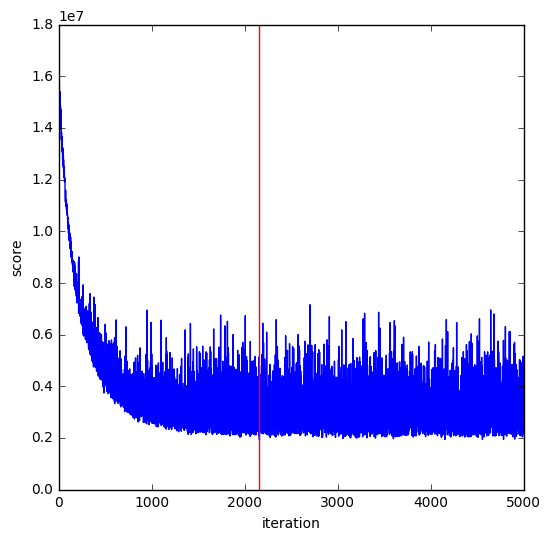

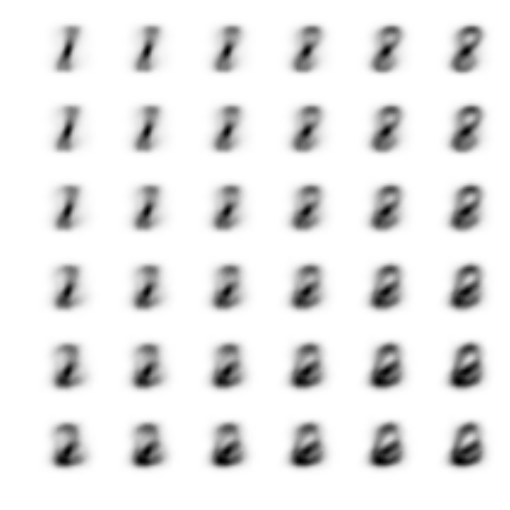

In [10]:
np.random.seed(0)

# centers randomly initialized
centers = np.random.rand(size_k ** 2, dim) * data_range

# neighborhood matrix
neighbor = np.arange(size_k ** 2).reshape((size_k, size_k))

# random order in which the datapoints should be presented
i_random = np.arange(tmax) % len(data)
np.random.shuffle(i_random)

scores = []
history = []

for t, i in enumerate(i_random):
    # at each iteration, compute the step and store the state
    score = som_step(centers, data[i, :], neighbor, eta, sigma)
    scores.append(score)

# show scores
plt.plot(scores)
plt.ylabel("score")
plt.xlabel("iteration")
plt.axvline(np.argmin(scores), color='red')
plt.show()

# visualize prototypes
plt.title('prototypes at best score')
for i in range(size_k ** 2):
    plt.subplot(size_k, size_k, i + 1)
    plt.imshow(centers[i,:].reshape([28, 28]), interpolation='bilinear', cmap='Greys')
    plt.axis('off')

plt.show()

We can see that each corner represents one of the four digits. In between the prototypes varies to pass to one digit to another.

In [11]:
closest_corners = []
corners = [[0, 0], [size_k - 1, 0], [0, size_k -1], [size_k, size_k]]
# for each entry, get closest corner
for e in data:
    df = [np.sum(np.square(centers[i, :] - e)) for i in range(size_k ** 2)]
    coords = np.ravel(np.nonzero(neighbor == np.argmin(df)))
    dists = np.linalg.norm(corners - coords, axis=1)
    closest_corners.append(np.argmin(dists))
closest_corners = np.array(closest_corners)

In [12]:
digits_assign = {}
for d in digits:
    digit_corners = closest_corners[np.where(labels == d)]
    # at least one bucket for each corner to avoid misindexing
    counts = np.bincount(np.r_[digit_corners, range(4)])
    major_corner = np.argmax(counts)
    digits_assign[major_corner] = d

In [13]:
digits_assign

{0: 1, 1: 2, 2: 8, 3: 6}

In [14]:
labels_assign = [digits_assign.get(c) for c in closest_corners]
np.count_nonzero(labels_assign != labels) / labels.shape[0]

0.3065

## Exploration